/tmp/ipykernel_15062/2276067005.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/home/federico/miniconda3/envs/snl/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


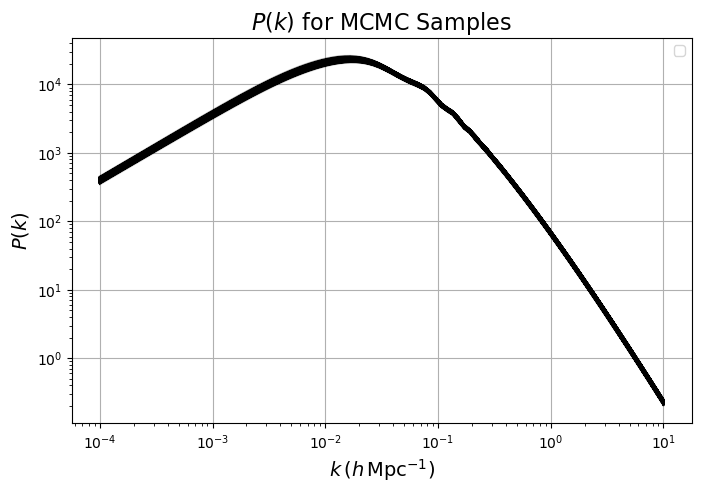

In [1]:
import numpy as np
from getdist import loadMCSamples
from colossus.cosmology import cosmology
#from colossus.lss import power
import matplotlib.pyplot as plt

# Load MCMC samples using GetDist
chain_root = '../data/CosmoParams/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE'
samples = loadMCSamples(chain_root)

# Extract relevant parameters for each sample
omega_m = samples.samples[:, samples.index['omegam']]
sigma_8 = samples.samples[:, samples.index['sigma8']]
H_0 = samples.samples[:, samples.index['H0']] # if 'H0' in samples.paramNames.names else 67.2  # Planck value
omega_bh2 = samples.samples[:, samples.index['omegabh2']]
omega_b = omega_bh2/(H_0/100)**2
n_s = samples.samples[:, samples.index['ns']]  # Scalar spectral index

# Define k values for the power spectrum
k_values = np.logspace(-4, 1, 100)  # k range from 10^-4 to 10^1 h/Mpc

# Prepare to store P(k) for each sample
P_k = []

# Loop over each sample to calculate P(k)
for i in range(len(omega_m)):
    cosmo_params = {
        'Om0': omega_m[i],
        'sigma8': sigma_8[i],
        'H0': H_0[i], #h[i] if isinstance(h, np.ndarray) else h*100,
        'Ob0': omega_b[i],
        'ns': n_s[i]
    }

    # Set the cosmology for this set of parameters
    cosmo = cosmology.setCosmology('myCosmo', params = cosmology.cosmologies['planck18'], **cosmo_params)

    #cosmology.setCurrent(cosmo_params)

    # Calculate P(k) using COLOSSUS
    P = cosmo.matterPowerSpectrum(k_values,z=0.0)
    P_k.append(P)

# Convert to a NumPy array for easier manipulation
P_k = np.array(P_k)

# Example plot for the first sample
plt.figure(figsize=(8, 5))
for i in range(len(omega_m)):
    plt.loglog(k_values, P_k[i],c='k',alpha=.05)#, label='Sample 1')
plt.title(r'$P(k)$ for MCMC Samples', fontsize=16)
plt.xlabel(r'$k \, (h \, \text{Mpc}^{-1})$', fontsize=14)
plt.ylabel(r'$P(k)$', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_15062/1691394679.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


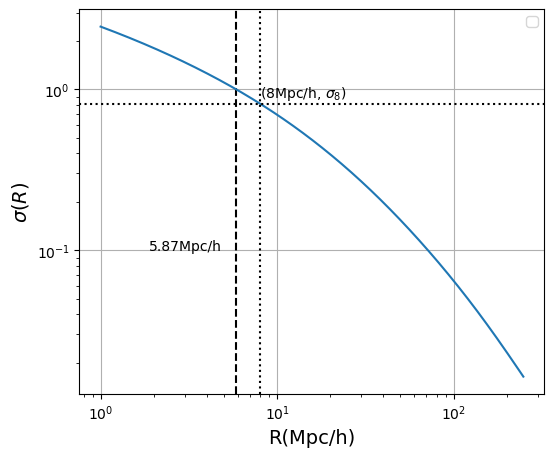

In [2]:
R = 10**np.arange(0,2.4,0.005)
sigma_tophat = cosmo.sigma(R, z=0.0)

def get_Rnl(R,sigma,sigma_nl=1):
    from scipy.interpolate import CubicSpline
    spl = CubicSpline(R,sigma-sigma_nl)
    return spl.roots(sigma_nl)[0]

plt.figure(figsize=(6, 5))
plt.loglog()

# R para sigma=1
R_nl = cosmo.sigma(1, z=0, inverse=True)
plt.axvline(R_nl,ls='--',c='k')
plt.text(R_nl-4,1e-1,f'{R_nl:.2f}Mpc/h')

# Sigma vs R
plt.plot(R, sigma_tophat, '-')

# Chequear que sigma(R=8) == sigma8 de la cadena MCMC
plt.axhline(sigma_8[-1],ls=':',c='k')
plt.axvline(8,ls=':',c='k')
plt.text(8.05,sigma_8[-1]+.08,r'(8Mpc/h, $\sigma_8$)')

plt.xlabel('R(Mpc/h)', fontsize=14)
plt.ylabel(r'$\sigma(R)$', fontsize=14)
plt.grid(True)
plt.legend()

In [3]:
def get_Rnl(R,sigma,sigma_nl=1):
    from scipy.interpolate import CubicSpline
    spl = CubicSpline(R,sigma-sigma_nl)
    return spl.roots(sigma_nl)[0]

def get_Snl(samples, zs):

    import numpy as np
    from colossus.cosmology import cosmology

    # Extract relevant parameters for each sample
    omega_m = samples.samples[:, samples.index['omegam']]
    sigma_8 = samples.samples[:, samples.index['sigma8']]
    H0 = samples.samples[:, samples.index['H0']] # if 'H0' in samples.paramNames.names else 67.2  # Planck value
    omega_bh2 = samples.samples[:, samples.index['omegabh2']]
    omega_b = omega_bh2/(H0/100)**2
    n_s = samples.samples[:, samples.index['ns']]  # Scalar spectral index

#    # R to calculate Sigma(R)
#    R = 10**np.arange(0,2.4,0.005)

    # Set array for storing S_nl
    S_nl = np.zeros((len(zs),len(omega_m)))

    for j in range(len(zs)):
        for i in range(len(omega_m)):
            cosmo_params = {
                'Om0': omega_m[i],
                'sigma8': sigma_8[i],
                'H0': H0[i], #if isinstance(H0, np.ndarray) else h*100,
                'Ob0': omega_b[i],
                'ns': n_s[i]
            }

            # Set the cosmology for this set of parameters
            cosmo = cosmology.setCosmology('myCosmo', params = cosmology.cosmologies['planck18'], **cosmo_params)

            # Get R_nl
            #sigma_tophat = cosmo.sigma(R, z=zs[j])
            #R_nl = get_Rnl(R,sigma_tophat,1)
            R_nl  = cosmo.sigma(1, z=zs[j], inverse=True)
            
            # Get Dv
            D_H = cosmo.comovingDistance(z_min=0,z_max=zs[j]) #Comoving distance
            D_M = (1+zs[j])*cosmo.angularDiameterDistance(zs[j]) #Angular diameter distance
            #D_M = cosmo.angularDiameterDistance(zs[j]) #Angular diameter distance
            D_V = (D_H*D_M**2)**(1./3)

            # Get S_NL
            S_nl[j,i] = R_nl/D_V

    return S_nl

from getdist import loadMCSamples
import matplotlib.pyplot as plt

chain_root_cmb = '../data/CosmoParams/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE'
chain_root_cl = '../data/CosmoParams/base/DES_DESpriors/base_DES_DESpriors'

zs = [0.1]

# Load MCMC samples using GetDist
samples_cmb = loadMCSamples(chain_root_cmb)
#samples_cl = loadMCSamples(chain_root_cl)

s_nl_cmb = get_Snl(samples_cmb,zs)
#s_nl_cl = get_Snl(samples_cl,zs)


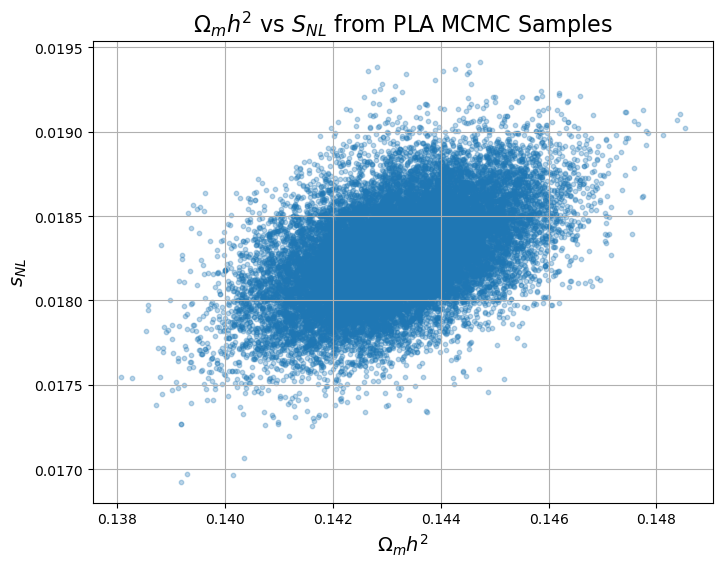

In [4]:

# Plotting Omega_m vs s_nl
# ------------------------------
omegamh2_cmb = samples_cmb.samples[:, samples_cmb.index['omegamh2']]
#omegam_cl = samples_cl.samples[:, samples_cl.index['omegam']]

plt.figure(figsize=(8, 6))
for i in range(len(s_nl_cmb)):
    plt.scatter(omegamh2_cmb, s_nl_cmb[i], alpha=0.3, color='C00', s=10)
    #plt.scatter(omegam_cl*h**2, s_nl_cl[i], alpha=0.3, color='C01', s=10)
plt.xlabel(r'$\Omega_m h^2$', fontsize=14)
plt.ylabel(r'$s_{NL}$', fontsize=14)
plt.title(r'$\Omega_m h^2$ vs $S_{NL}$ from PLA MCMC Samples', fontsize=16)
plt.grid(True)
plt.show()

In [6]:
def get_snl(samples,zs):
    """
    samples: MCMC samples (getdist)
    zs: redshifts (np array)
    """
    from colossus.cosmology import cosmology

    # Extract relevant parameters for each sample
    omega_m = samples.samples[:, samples.index['omegam']]
    sigma_8 = samples.samples[:, samples.index['sigma8']]
    H0 = samples.samples[:, samples.index['H0']] # if 'H0' in samples.paramNames.names else 67.2  # Planck value
    omega_b = samples.samples[:, samples['omegab']] if 'omegab' in samples.paramNames.names else \
        samples.samples[:,samples.index['omegabh2']]/(H0/100)**2
    n_s = samples.samples[:, samples.index['ns']]  # Scalar spectral index

    # Set output arrays
    snl = np.zeros((len(zs),len(omega_m)))
    rnl = np.zeros((len(zs),len(omega_m)))
    D_V = np.zeros((len(zs),len(omega_m)))
    D_A = np.zeros((len(zs),len(omega_m)))
    D_M = np.zeros((len(zs),len(omega_m)))
    s12 = np.zeros((len(zs),len(omega_m)))

    for i in range(len(omega_m)):
        cosmo_params = {
            'Om0': omega_m[i],
            'sigma8': sigma_8[i],
            'H0': H0[i],
            'Ob0': omega_b[i],
            'ns': n_s[i]
        }

        # Set the cosmology for this set of parameters
        cosmo = cosmology.setCosmology('myCosmo', params=cosmology.cosmologies['planck18'], **cosmo_params)

        # Get r non-linear
        rnl[:,i]  = cosmo.sigma(1, z=zs, inverse=True)
        s12[:,i]  = cosmo.sigma(12, z=zs, inverse=False)

        # Get Dv
        D_H = cosmo.comovingDistance(z_min=np.zeros((len(zs))),z_max=zs, transverse=False) #Comoving distance
        D_A[:,i] = cosmo.angularDiameterDistance(zs) #Angular diameter distance
        D_M[:,i] = (1+zs)*D_A[:,i]
        D_V[:,i] = (D_H*D_M[:,i]**2)**(1./3) #Volume-averaged distance

        # Get s non-linear
        snl[:,i] = rnl[:,i]/D_V[:,i]

    return snl, rnl, D_V, s12, D_A, D_M


import numpy as np 
from getdist import loadMCSamples
import matplotlib.pyplot as plt

chain_root_cmb = '../data/CosmoParams/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE'
chain_root_des = '../data/CosmoParams/base/DES_DESpriors/base_DES_DESpriors'

samples_cmb = loadMCSamples(chain_root_cmb)
samples_des = loadMCSamples(chain_root_des)

zs = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

snl_cmb, rnl_cmb, Dv_cmb, s12_cmb, DA_cmb, DM_cmb = get_snl(samples_cmb,zs)
snl_des, rnl_des, Dv_des, s12_des, DA_des, DM_des = get_snl(samples_des,zs)

# Calculate wm = Om h^2
# CMB
omegamh2_cmb = samples_cmb.samples[:, samples_cmb.index['omegamh2']]
# DES
omegamh2_des = samples_des.samples[:, samples_des.index['omegamh2']] if 'omegamh2' in \
    samples_des.paramNames.names else \
        samples_des.samples[:, samples_des.index['omegam']]*(samples_des.samples[:, samples_des.index['H0']]/100)**2


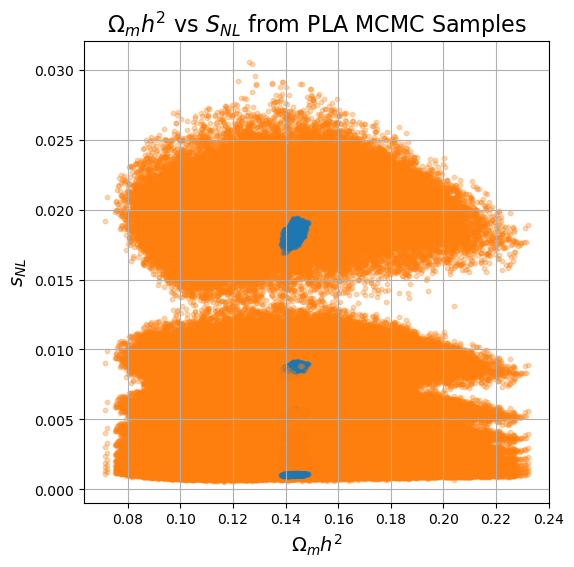

In [7]:
# ------------------------------
# Plotting Omega_m vs s_nl
# ------------------------------

plt.figure(figsize=(6, 6))
for i in range(len(snl_des)):
    plt.scatter(omegamh2_des, snl_des[i], alpha=0.3, color='C01', s=10)
    plt.scatter(omegamh2_cmb, snl_cmb[i], alpha=0.3, color='C00', s=10)

plt.xlabel(r'$\Omega_m h^2$', fontsize=14)
plt.ylabel(r'$s_{NL}$', fontsize=14)
plt.title(r'$\Omega_m h^2$ vs $S_{NL}$ from PLA MCMC Samples', fontsize=16)
plt.grid(True)
plt.show()

In [8]:
# chain_root_cmb = '../data/CosmoParams/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE'
# chain_root_cl = '../data/CosmoParams/base/DES_DESpriors/base_DES_DESpriors'

# samples_cmb = loadMCSamples(chain_root_cmb)
# samples_cl = loadMCSamples(chain_root_cl)

samples_cmb.addDerived(snl_cmb[0], name='s_nl', label=r's_{NL}')
samples_cmb.addDerived(rnl_cmb[0], name='r_nl', label=r'r_{NL}')
samples_cmb.addDerived(s12_cmb[0], name='sigma12', label=r'\sigma_{12}')
#samples_cmb.addDerived(omegamh2_cmb, name='omegamh2', label=r'\Omega_m h^2')

samples_des.addDerived(rnl_des[0], name='r_nl', label=r'r_{NL}')
samples_des.addDerived(snl_des[0], name='s_nl', label=r's_{NL}')
samples_des.addDerived(s12_des[0], name='sigma12', label=r'\sigma_{12}')
samples_des.addDerived(omegamh2_des, name='omegamh2', label=r'\Omega_m h^2')



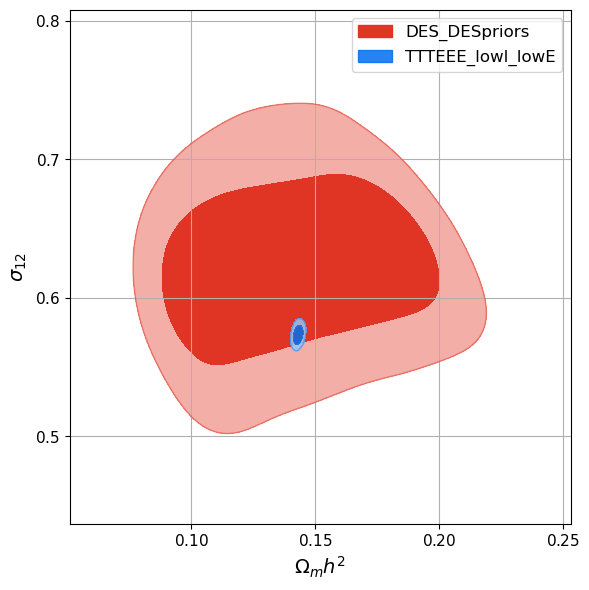

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from getdist import loadMCSamples, plots, MCSamples

# Create a GetDist plotter object
g = plots.get_subplot_plotter(subplot_size=6)

# Specify which parameters to plot (Omega_m and sigma_8)
param_names = ['omegamh2', 'sigma12']

# Plot labels
labels = ['DES_DESpriors','TTTEEE_lowl_lowE']

# Generate the 2D plot with contours for Omega_m vs sigma_8
g.plot_2d([samples_des,samples_cmb], param_names, filled=True, legend_labels=labels)
g.add_legend(labels)

plt.grid(True)
plt.show()

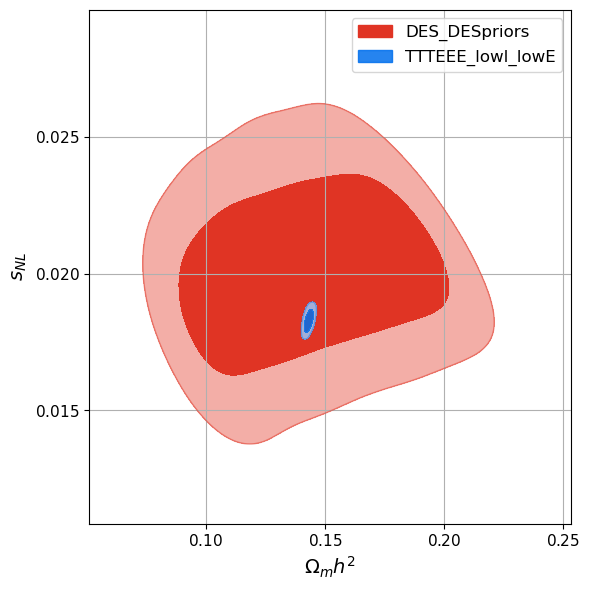

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from getdist import loadMCSamples, plots, MCSamples

# Create a GetDist plotter object
g = plots.get_subplot_plotter(subplot_size=6)

# Specify which parameters to plot (Omega_m and sigma_8)
param_names = ['omegamh2', 's_nl']

# Plot labels
labels = ['DES_DESpriors','TTTEEE_lowl_lowE']

# Generate the 2D plot with contours for Omega_m vs sigma_8
g.plot_2d([samples_des,samples_cmb], param_names, filled=True, legend_labels=labels)
g.add_legend(labels)

# Add axis labels and title
#g.export('omega_m_vs_sigma_8_plot.png')  # Save the plot if desired
#plt.title(r'$\Omega_m$ vs $\sigma_8$ from PLA MCMC Samples', fontsize=16)
plt.grid(True)
plt.show()


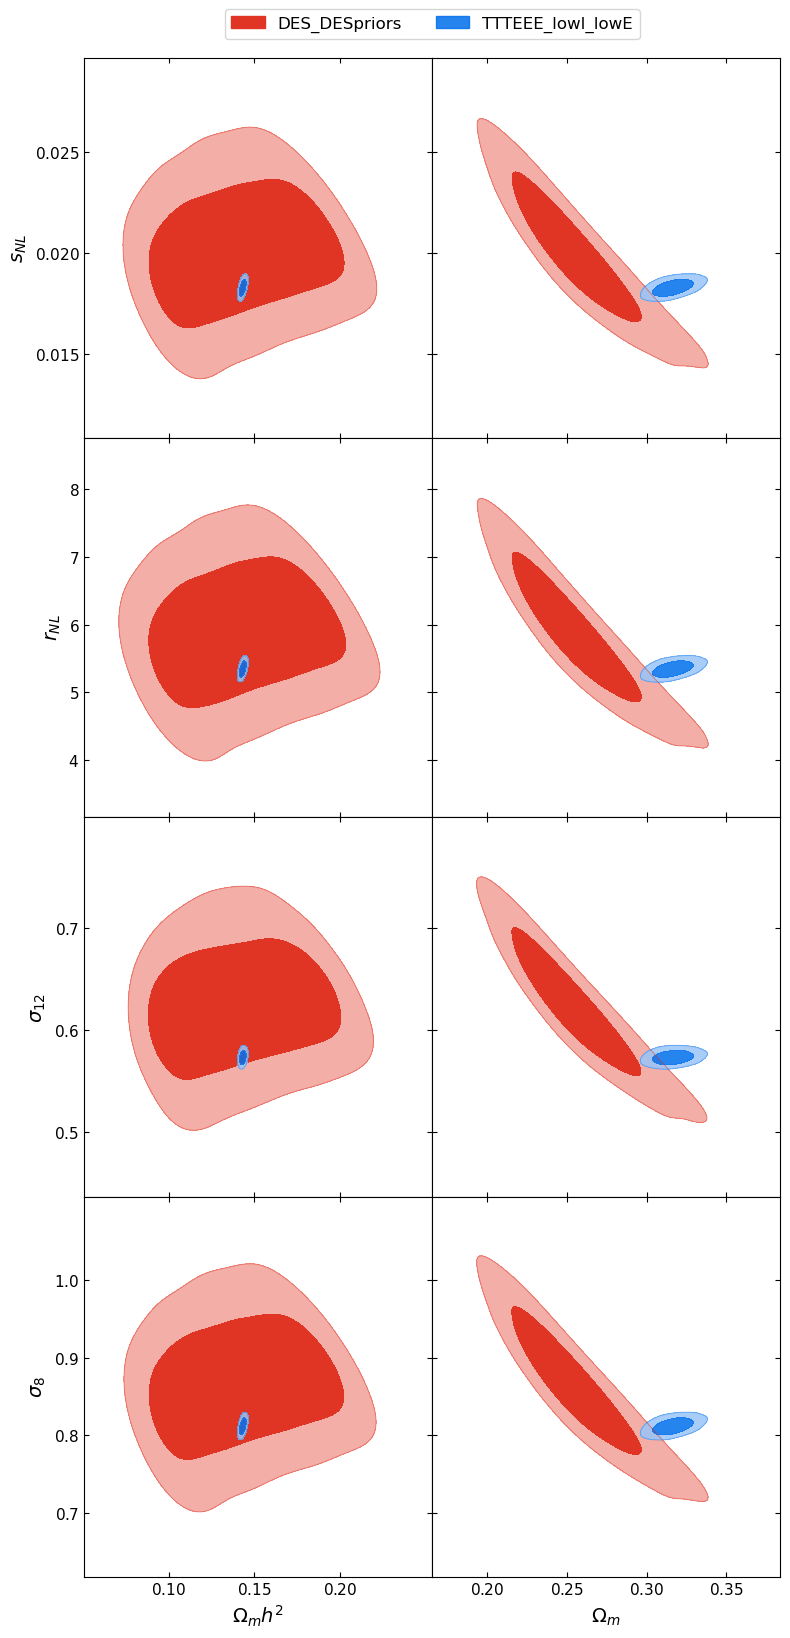

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from getdist import loadMCSamples, plots, MCSamples

# Create a GetDist plotter object
g = plots.get_subplot_plotter(subplot_size=4)

# Specify which parameters to plot (Omega_m and sigma_8)
#param_names = ['omegamh2', 's_nl']

# Plot labels
labels = ['DES_DESpriors','TTTEEE_lowl_lowE']

# Generate the 2D plot with contours for Omega_m vs sigma_8
g.rectangle_plot(xparams=['omegamh2','omegam'],yparams=['s_nl','r_nl','sigma12', 'sigma8'],roots=[samples_des,samples_cmb],\
                 filled=True, legend_labels=labels, grid=True);

# Add axis labels and title
#g.export('omega_m_vs_sigma_8_plot.png')  # Save the plot if desired
#plt.title(r'$\Omega_m$ vs $\sigma_8$ from PLA MCMC Samples', fontsize=16)
#g.grid(True)
plt.show()


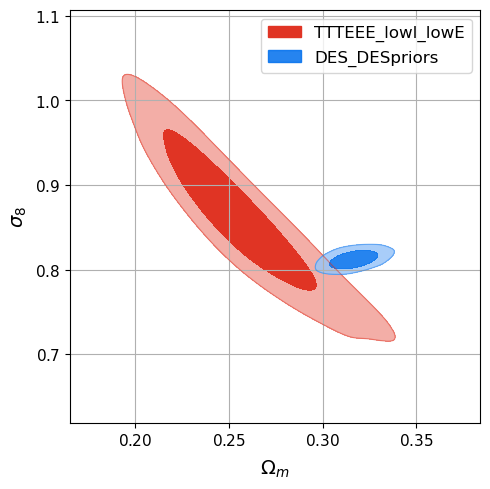

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from getdist import loadMCSamples, plots

# Root path to your chain files (do not include file extensions)
chain_root = '../data/CosmoParams/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE'
chain_root_lens = '../data/CosmoParams/base/DES_DESpriors/base_DES_DESpriors'
chain_root_wmap = '../data/CosmoParams/base/WMAP/base_WMAP'

# Load the MCMC samples using GetDist's loadMCSamples
samples_1 = loadMCSamples(chain_root)
samples_2 = loadMCSamples(chain_root_lens)

# Create a GetDist plotter object
g = plots.get_subplot_plotter(subplot_size=5)

# Specify which parameters to plot (Omega_m and sigma_8)
param_names = ['omegam', 'sigma8']

# Plot labels
labels = ['TTTEEE_lowl_lowE','DES_DESpriors']

# Generate the 2D plot with contours for Omega_m vs sigma_8
g.plot_2d([samples_2,samples_1], param_names, filled=True, legend_labels=labels)
#g.add_legend()

g.add_legend(labels)

# Add axis labels and title
#g.export('omega_m_vs_sigma_8_plot.png')  # Save the plot if desired
#plt.title(r'$\Omega_m$ vs $\sigma_8$ from PLA MCMC Samples', fontsize=16)
plt.grid(True)
plt.show()


[ 1.56896878e-06 -1.47983327e-06 -3.09104803e-08 -8.05280498e-07
 -5.41290585e-07 -1.04058042e-06 -1.82628863e-07 -8.42493106e-07
  7.85611927e-08 -6.28510652e-08]


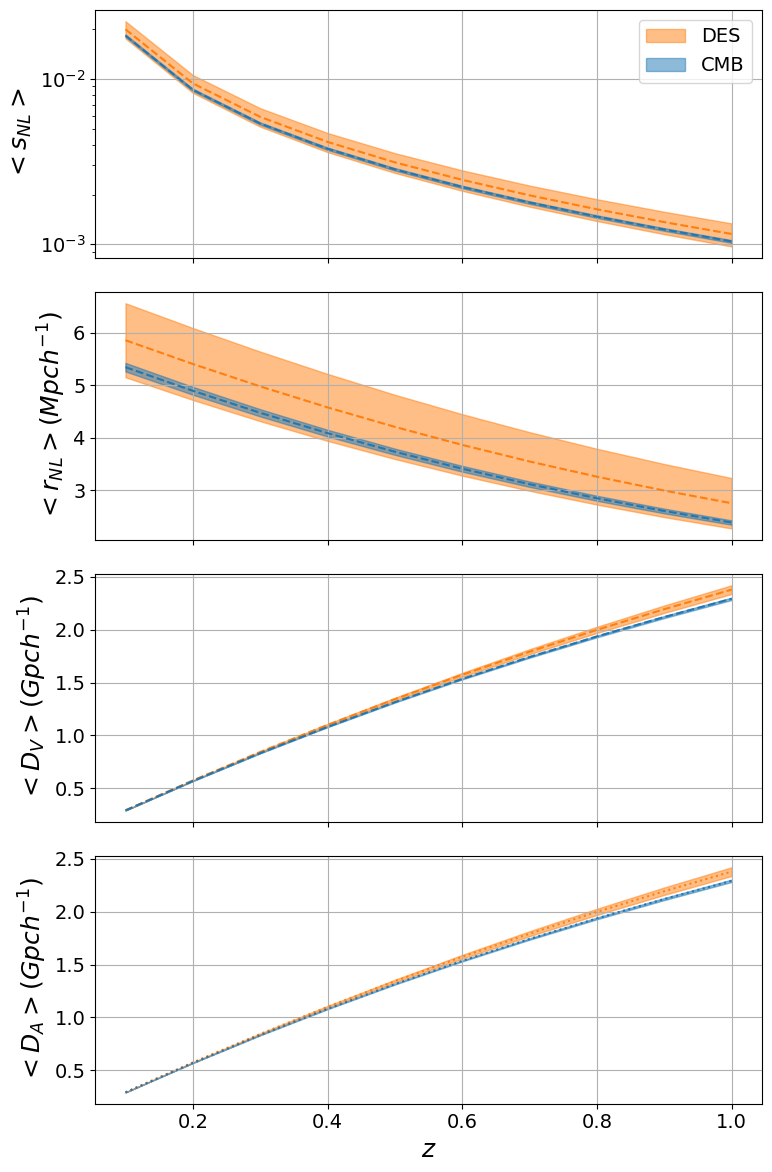

: 

In [23]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16, 'axes.labelsize': 18, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14})

fig, axs = plt.subplots(4, 1, figsize=(8, 12),sharex=True)

# Optional: Add a title and axis labels
#plt.title("r and s non linear vs redshift")
axs[0].set_ylabel(r"$<s_{NL}>$")
axs[1].set_ylabel(r"$<r_{NL}> (Mpc h^{-1})$")
axs[2].set_ylabel(r"$<D_V> (Gpc h^{-1})$")
axs[3].set_ylabel(r"$<D_A> (Gpc h^{-1})$")

axs[-1].set_xlabel(r"$z$")

# Plot data with optional formatting (line style, color, marker, etc.)
snl_cmb_mean = np.mean(snl_cmb,axis=1)
snl_des_mean = np.mean(snl_des,axis=1)
snl_cmb_std = np.std(snl_cmb,axis=1,ddof=1)
snl_des_std = np.std(snl_des,axis=1,ddof=1)

Dv_cmb_mean = np.mean(Dv_cmb/1000.,axis=1)
Dv_des_mean = np.mean(Dv_des/1000.,axis=1)
Dv_cmb_std = np.std(Dv_cmb/1000.,axis=1,ddof=1)
Dv_des_std = np.std(Dv_des/1000.,axis=1,ddof=1)

DM_cmb_mean = np.mean(DM_cmb/1000.,axis=1)
DM_des_mean = np.mean(DM_des/1000.,axis=1)
DM_cmb_std = np.std(DM_cmb/1000.,axis=1,ddof=1)
DM_des_std = np.std(DM_des/1000.,axis=1,ddof=1)

rnl_cmb_mean = np.mean(rnl_cmb,axis=1)
rnl_des_mean = np.mean(rnl_des,axis=1)
rnl_cmb_std = np.std(rnl_cmb,axis=1,ddof=1)
rnl_des_std = np.std(rnl_des,axis=1,ddof=1)

axs[0].fill_between(zs, snl_des_mean-snl_des_std, snl_des_mean+snl_des_std, label='DES', \
             linestyle='-', color='C01', alpha=.5)
axs[0].fill_between(zs, snl_cmb_mean-snl_cmb_std, snl_cmb_mean+snl_cmb_std, label='CMB', \
             linestyle='-', color='C00', alpha=.5)
axs[0].plot(zs, snl_des_mean, linestyle='--', color='C01')
axs[0].plot(zs, snl_cmb_mean, linestyle='--', color='C00')


axs[1].fill_between(zs, rnl_des_mean-rnl_des_std, rnl_des_mean+rnl_des_std,\
             linestyle='-', color='C01', alpha=.5)
axs[1].fill_between(zs, rnl_cmb_mean-rnl_cmb_std, rnl_cmb_mean+rnl_cmb_std,\
             linestyle='-', color='C00', alpha=.5)
axs[1].plot(zs, rnl_des_mean, linestyle='--', color='C01')
axs[1].plot(zs, rnl_cmb_mean, linestyle='--', color='C00')


axs[2].fill_between(zs, Dv_des_mean-Dv_des_std, Dv_des_mean+Dv_des_std,\
             linestyle='-', color='C01', alpha=.5)
axs[2].fill_between(zs, Dv_cmb_mean-Dv_cmb_std, Dv_cmb_mean+Dv_cmb_std,\
             linestyle='-', color='C00', alpha=.5)
axs[2].plot(zs, Dv_des_mean, linestyle='--', color='C01')
axs[2].plot(zs, Dv_cmb_mean, linestyle='--', color='C00')

axs[3].fill_between(zs, DM_des_mean-DM_des_std, DM_des_mean+DM_des_std,\
             linestyle='-', color='C01', alpha=.5)
axs[3].fill_between(zs, DM_cmb_mean-DM_cmb_std, DM_cmb_mean+DM_cmb_std,\
             linestyle='-', color='C00', alpha=.5)
axs[3].plot(zs, DM_des_mean, linestyle=':', color='C01')
axs[3].plot(zs, DM_cmb_mean, linestyle=':', color='C00')

axs[0].legend()
for ax in axs:
    ax.grid(True)


axs[0].set_yscale('log')
plt.tight_layout()
print(DM_cmb_mean-Dv_cmb_mean)
plt.show()


# plt.savefig("plot.png")


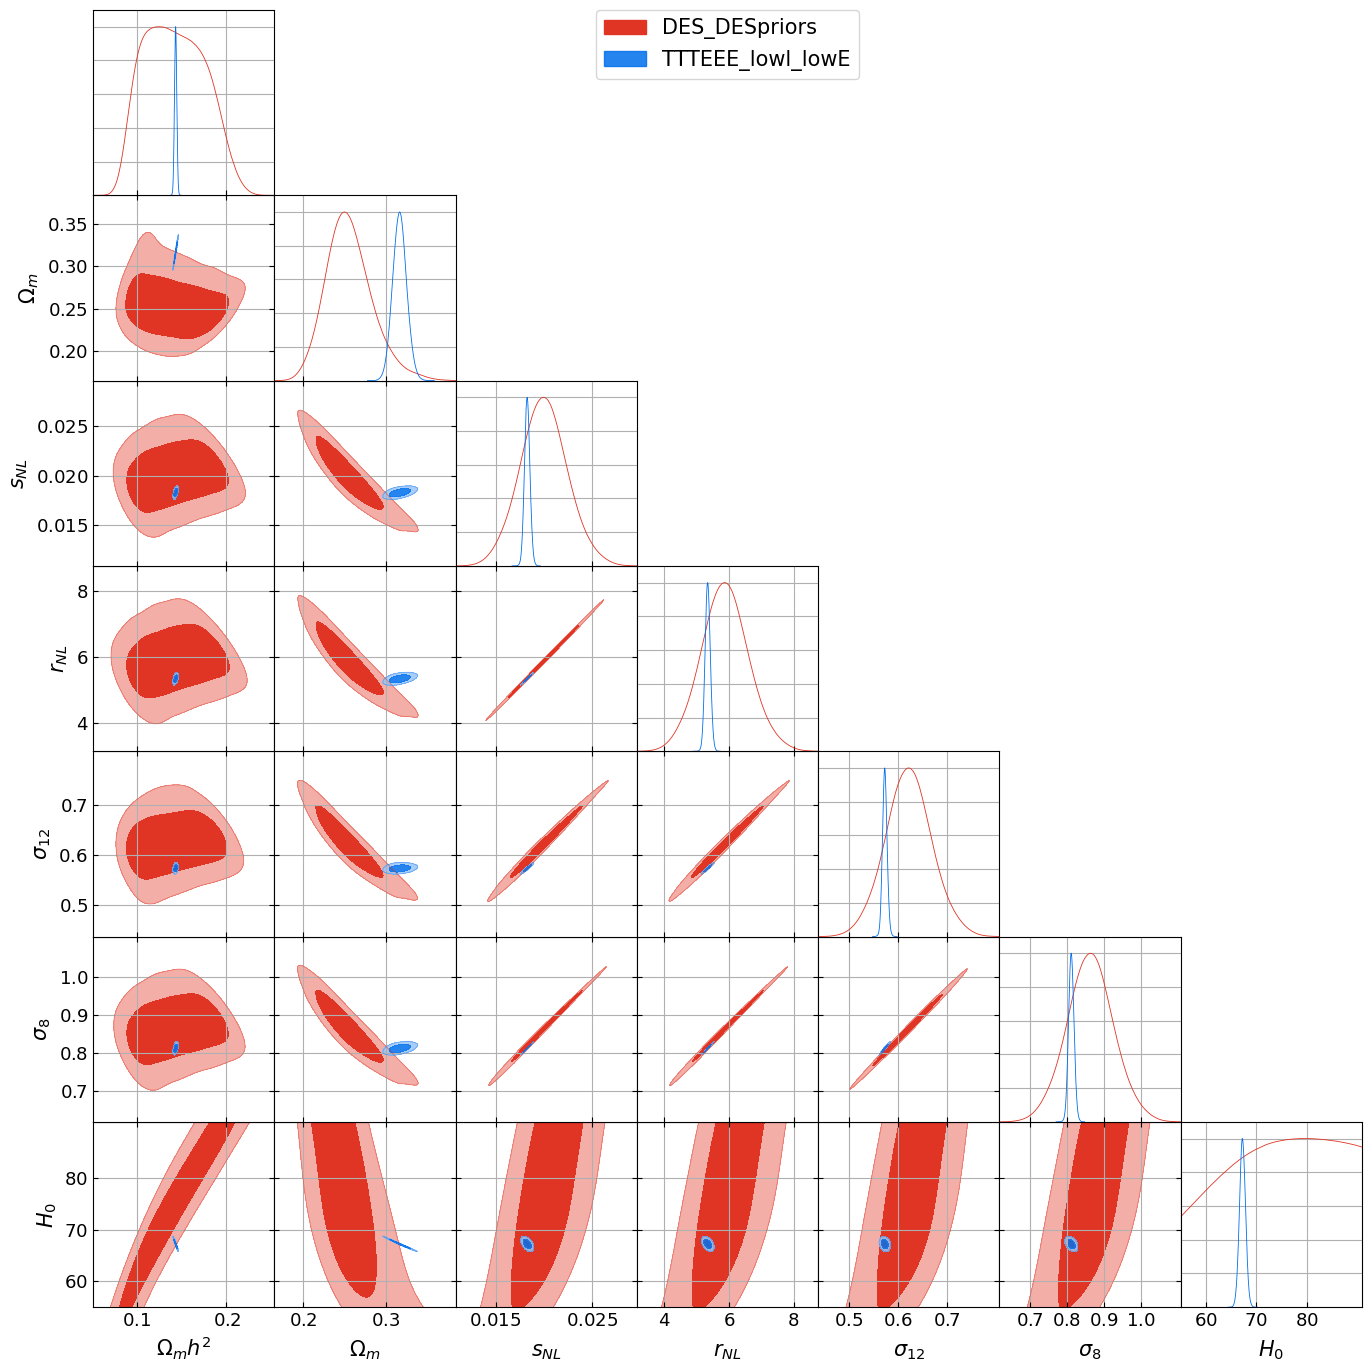

In [14]:
colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']
# Create a GetDist plotter
g = plots.get_subplot_plotter()

# Settings
g.settings.lab_fontsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 18

# Plot labels
labels = ['DES_DESpriors','TTTEEE_lowl_lowE']

# Generate the 2D plot with contours for Omega_m vs sigma_8
g.triangle_plot([samples_des,samples_cmb],params=['omegamh2','omegam','s_nl','r_nl','sigma12', 'sigma8','H0'],\
                 filled=True, legend_labels=labels, grid=True)

# Enable the grid on each subplot, only if the axis is not None
for ax in g.subplots.flat:  # Flatten subplots to loop over all
    if ax:  # Check if ax is not None
        ax.grid(True)

# Show the plot
plt.show()  

#### Plot D_A
#### Express r and D_A/V in Mpc